# Sort&Rank

### Eliminating irrelevant papers


In [ ]:
from __future__ import annotations
import re
import sys
import unicodedata
from pathlib import Path

import pandas as pd

# ---- Configuration -----------------------------------------------------------

# Pattern/glob for your input files:
INPUT_GLOB = "csv_output/100_manual_check/classified_*_papers.csv"

# Output directory (created if it doesn't exist)
OUTPUT_DIR = Path("csv_output/101_sorted_manual_check")

# Column that defines the grouping
REASON_COL = "Reason"

# -----------------------------------------------------------------------------

YEAR_RE = re.compile(r"(?<!\d)(20\d{2})(?!\d)")  # match a standalone 4-digit year 2000–2099


def extract_year_from_name(path: Path) -> int:
    """
    Extract a 4-digit year from a filename like 'classified_2021_papers.csv'.
    Picks the first match of 20xx.
    """
    m = YEAR_RE.search(path.name)
    if not m:
        raise ValueError(f"Could not find a 4-digit year in filename: {path.name}")
    return int(m.group(1))


def slugify_filename(text: str, max_len: int = 120) -> str:
    """
    Create a safe, filesystem-friendly filename slug from arbitrary text.
    Keeps ASCII letters, digits, '-', '_' and collapses whitespace/punctuation to '_'.
    Preserves useful dashes by normalizing to ASCII where possible.
    """
    # Normalize unicode (e.g., fancy quotes/dashes) to NFKD, strip diacritics
    normalized = unicodedata.normalize("NFKD", text)
    ascii_only = normalized.encode("ascii", "ignore").decode("ascii")

    # Replace any sequence of non-alphanumeric characters with underscores
    slug = re.sub(r"[^A-Za-z0-9]+", "_", ascii_only).strip("_")

    # Collapse multiple underscores and trim length
    slug = re.sub(r"_+", "_", slug)
    return slug[:max_len] if max_len else slug


def main() -> int:
    input_paths = sorted(Path(".").glob(INPUT_GLOB))
    if not input_paths:
        print(f"No input files matched glob: {INPUT_GLOB}", file=sys.stderr)
        return 1

    # Load & add Year
    frames = []
    for p in input_paths:
        year = extract_year_from_name(p)
        try:
            df = pd.read_csv(p, encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(p, encoding="latin-1")
        df["Year"] = year
        frames.append(df)

    combined = pd.concat(frames, ignore_index=True)

    # Sanity check for required column
    if REASON_COL not in combined.columns:
        raise KeyError(
            f"Expected a '{REASON_COL}' column in the CSVs, but it wasn't found. "
            f"Available columns: {list(combined.columns)}"
        )

    # Make output directory
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    # Save the combined dataset (optional but handy)
    combined_path = OUTPUT_DIR / "all_years_combined.csv"
    combined.to_csv(combined_path, index=False)
    print(f"Wrote combined dataset: {combined_path}")

    # Aggregate counts by Reason × Year
    counts = (
        combined.groupby([REASON_COL, "Year"])
        .size()
        .reset_index(name="Count")
        .sort_values([REASON_COL, "Year"])
    )

    # Pivot to wide format for easier reading
    pivot = counts.pivot(index=REASON_COL, columns="Year", values="Count").fillna(0).astype(int)

    summary_path = OUTPUT_DIR / "summary_by_reason_year.csv"
    pivot.to_csv(summary_path)
    print(f"Wrote pivot summary:   {summary_path}")

    # Also save the long-form counts table if you want it
    long_counts_path = OUTPUT_DIR / "counts_by_reason_year_long.csv"
    counts.to_csv(long_counts_path, index=False)
    print(f"Wrote long counts:     {long_counts_path}")

    # Split into one CSV per Reason
    per_reason_dir = OUTPUT_DIR / "by_reason"
    per_reason_dir.mkdir(exist_ok=True)

    written = 0
    for reason, grp in combined.groupby(REASON_COL, dropna=False):
        # Handle NaN reasons gracefully
        reason_label = "Unspecified" if pd.isna(reason) else str(reason)
        slug = slugify_filename(reason_label)
        out_path = per_reason_dir / f"papers_{slug}.csv"
        grp.to_csv(out_path, index=False)
        written += 1
        print(f"Wrote: {out_path}")

    print(f"Done. {written} per-reason file(s) written.")

main()

Wrote combined dataset: csv_output\101_sorted_manual_check\all_years_combined.csv
Wrote pivot summary:   csv_output\101_sorted_manual_check\summary_by_reason_year.csv
Wrote long counts:     csv_output\101_sorted_manual_check\counts_by_reason_year_long.csv
Wrote: csv_output\101_sorted_manual_check\by_reason\papers_Eliminated_Materials_Envelope.csv
Wrote: csv_output\101_sorted_manual_check\by_reason\papers_Eliminated_Monitoring_Forecasting_only.csv
Wrote: csv_output\101_sorted_manual_check\by_reason\papers_Eliminated_Other_Industry.csv
Wrote: csv_output\101_sorted_manual_check\by_reason\papers_Eliminated_Planning_Top_down.csv
Wrote: csv_output\101_sorted_manual_check\by_reason\papers_Eliminated_Renewable_only.csv
Wrote: csv_output\101_sorted_manual_check\by_reason\papers_Eliminated_Ventilation_IAQ_only.csv
Wrote: csv_output\101_sorted_manual_check\by_reason\papers_Eliminated_star.csv
Wrote: csv_output\101_sorted_manual_check\by_reason\papers_Eliminated_unclear_other.csv
Wrote: csv_output

# Visualisation

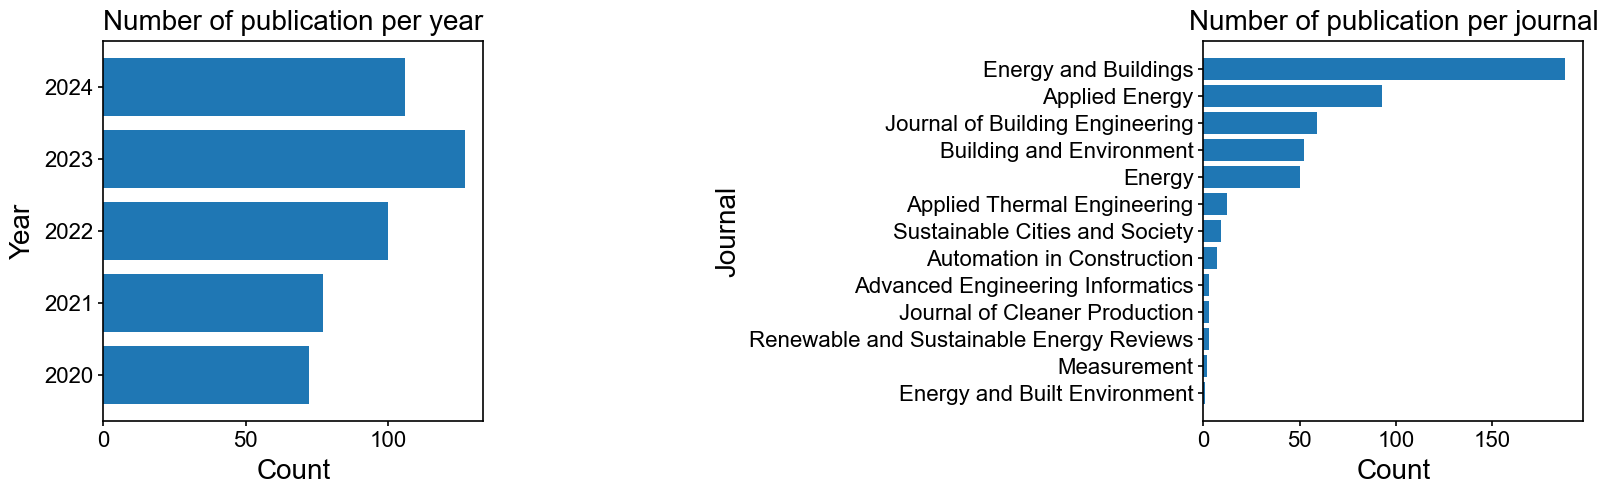

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
# ---------- global path ----------
final_path = "csv_output/300_manually_filtered/_final.csv"
# ---------- global style ----------
plt.rcParams.update({
    'font.family': ['Arial', 'sans-serif'],
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'legend.title_fontsize': 14,
    'figure.titlesize': 20,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'figure.autolayout': False,
})

# ---------- helpers for identical square frames ----------
# Two equal square axes boxes in a single row (in figure coordinates)
SQ = 0.38
AX_LEFT  = [0.09, 0.16, SQ, SQ]  # [left, bottom, width, height]
AX_RIGHT = [0.53, 0.16, SQ, SQ]  # gap ~0.06, right margin ~0.09
TITLEPAD = 8
LABELPAD = 6

def set_square_frame(ax, pos):
    """Pin ax to a square frame with identical size/position logic."""
    ax.set_position(pos)       # exact rectangle
    ax.set_box_aspect(1)       # ensure square inner frame
    ax.set_anchor('SW')        # anchor to bottom-left so padding doesn't shift
    # consistent padding
    t = ax.get_title()
    if t:
        ax.set_title(t, pad=TITLEPAD)
    ax.xaxis.labelpad = LABELPAD
    ax.yaxis.labelpad = LABELPAD
    # avoid tight/constrained layout (they'd move the axes)

# ---------- data ----------

if not os.path.exists(final_path):
    raise FileNotFoundError(
        f"Expected final file at '{final_path}' but it was not found. "
        "Please place your final CSV there with columns: DOI, Year, Title, Journal."
    )

df = pd.read_csv(final_path)

required = {"DOI", "Year", "Title", "Journal"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

# Clean + focus on 2020–2024
new_df = df.copy()
new_df["Year"] = pd.to_numeric(new_df["Year"], errors="coerce")
new_df = new_df.dropna(subset=["Year"]).copy()
new_df["Year"] = new_df["Year"].astype(int)
new_df = new_df[new_df["Year"].between(2020, 2024)]
new_df.to_csv("csv_output/101_sorted_manual_check/by_reason/filtered_years.csv", index=False)

# ---------- prep data ----------
# A) Year distribution (ensure all five years exist)
years = list(range(2020, 2025))
year_counts = (
    df.groupby("Year")
      .size()
      .reindex(years, fill_value=0)
      .reset_index()
)
year_counts.columns = ["Year", "Count"]

# B) Top journals
journal_counts = (
    df.groupby("Journal", as_index=False)
      .size()
      .rename(columns={"size": "Count"})
      .sort_values(["Count", "Journal"], ascending=[False, True])
)
TOP_N = 15
topN = journal_counts.head(TOP_N).iloc[::-1]  # reverse so the largest ends up at top in barh

# ---------- figure & subplots (in a row) ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))  # height controls physical square size

# Plot 1: Year distribution — horizontal (Count on x-axis)
ax1.barh(year_counts["Year"].astype(str), year_counts["Count"])
ax1.set_title("Number of publication per year")
ax1.set_xlabel("Count")
ax1.set_ylabel("Year")
set_square_frame(ax1, AX_LEFT)
# Plot 2: Top journals — horizontal (Count on x-axis)
ax2.barh(topN["Journal"], topN["Count"])
ax2.set_title(f"Number of publication per journal")
ax2.set_xlabel("Count")
ax2.set_ylabel("Journal")
set_square_frame(ax2, AX_RIGHT)
plt.show()

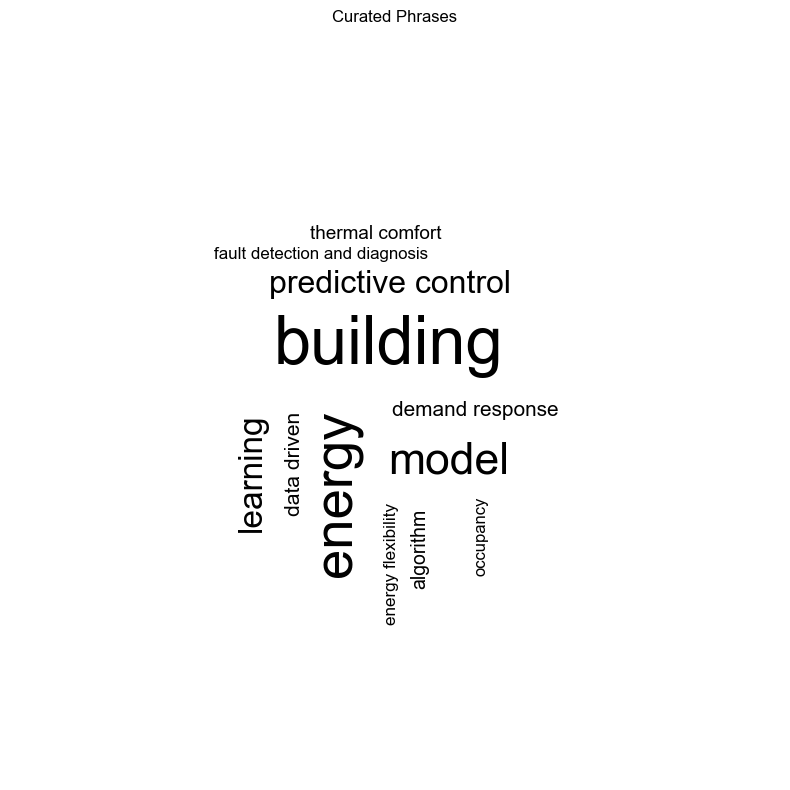

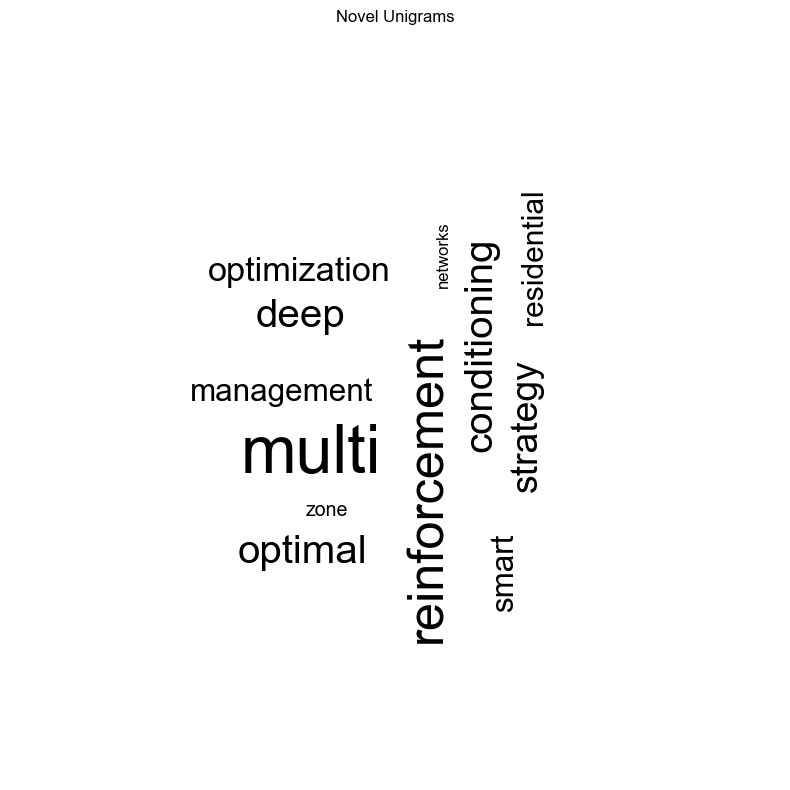

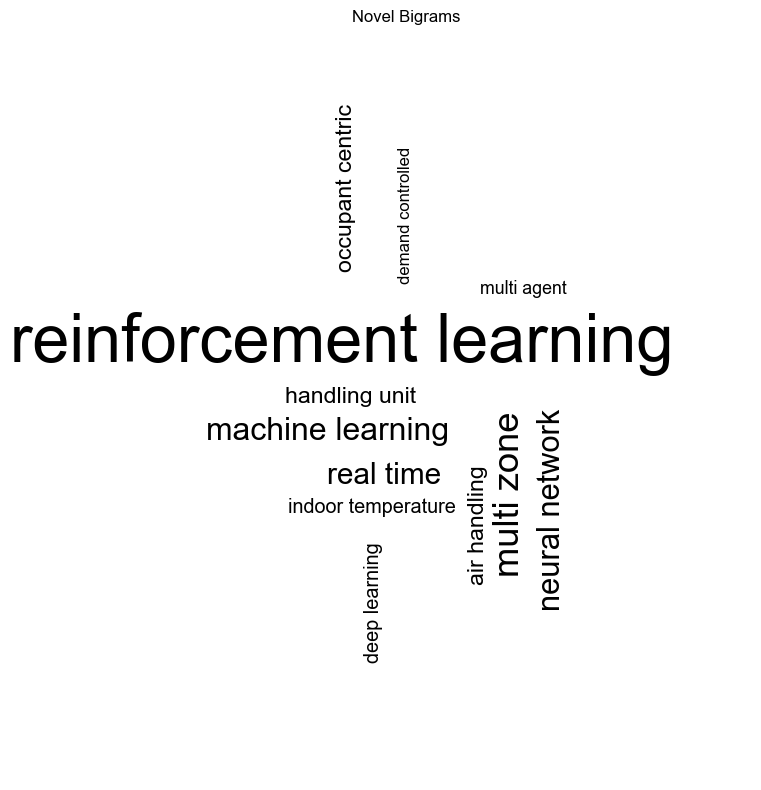

In [5]:
import os, re, math, random, unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import tee
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
random.seed(11)

# ------------ paths ------------
FINAL_CSV_PATH = "csv_output/300_manually_filtered/_final.csv"  # Single path instead of list
KEYWORDS_CSV = "csv/_keywords.csv"

TOP_N = 12                # show more terms
TRIGRAM_SUPPRESS_MIN = 3   # optional, currently not used (we focus on derivative exclusion)

# ------------ helpers ------------
def normalize_text(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    return (s.replace("\ufb01","fi").replace("\ufb02","fl")
             .replace("–","-").replace("—","-"))

TOKEN_RE = re.compile(r"[a-zA-Z]{2,}")
CUR_TOKEN_RE = re.compile(r"[a-zA-Z]{2,}")  # curated terms tokenizer (no STOP filtering)

# Title-token STOP set (to keep Plot B readable)
STOP = {
    "the","and","for","with","from","into","over","under","after","before","of","in","on","to",
    "an","a","by","at","as","or","via","using","use","based","towards","toward","within",
    "study","analysis","approach","method","methods","effect","effects","case","cases","new","model",
    "framework","application","applications","experimental","numerical",
    "building","buildings","energy","system","systems","data","control","controls",
    "operational","operation","operations",
}
ALLOW_SHORT = {"ai","rl","dr","mpc","bms"}
# --- manual exclusions for Plot B (novel bigrams) ---
# tokens are checked after canonicalization, so 'DR', 'dr', 'Dr.' all map to 'dr'
MANUAL_EXCLUDE_TOKENS = {

}

# exact bigram exclusions in canonical space: "word1 word2"
MANUAL_EXCLUDE_CANON_BIGRAMS = {
    "deep reinforcement",
    "model predictive",
    "loc post",    
}

def tokenize(txt: str):
    """Tokenize titles for bigram building (applies STOP & short filtering)."""
    toks = TOKEN_RE.findall(str(txt).lower())
    return [t for t in toks if (len(t) >= 3 or t in ALLOW_SHORT) and t not in STOP]

def curated_tokenize(phrase: str):
    """Tokenize curated phrases WITHOUT STOP removal (we want all words)."""
    return CUR_TOKEN_RE.findall(str(phrase).lower())

def unigrams(tokens):
    """Return single tokens."""
    return tokens

def bigrams(tokens):
    a, b = tee(tokens); next(b, None)
    return list(zip(a, b))

def trigrams(tokens):
    a, b, c = tee(tokens, 3)
    next(b, None); next(c, None); next(c, None)
    return list(zip(a, b, c))

def canon(tok: str) -> str:
    """Light canonicalizer for morphology (detect/detection/detecting -> detect)."""
    if tok in ALLOW_SHORT: return tok
    for suf in ("ing","tion","tions","sion","sions","oses","ies","es","ed","s"):
        if len(tok) > 4 and tok.endswith(suf):
            return tok[:-len(suf)]
    return tok

def phrase_to_regex(phrase: str):
    parts = [re.escape(t) + r"\w*" for t in re.split(r"[-\s]+", phrase.strip()) if t]
    if not parts: return None
    return re.compile(r"(?:%s)" % r"[-\s]*".join(parts), re.IGNORECASE)

def split_terms(s: str):
    if pd.isna(s): return []
    return [x.strip() for x in re.split(r"[;,]", str(s)) if x.strip()]

def draw_tag(items, title):
    if not items:
        print(title + ": no phrases to display."); return

    # --- size scaling: compress range a bit to reduce crowding ---
    vals = [v for _, v in items]; vmin, vmax = min(vals), max(vals)
    fmin, fmax = 12, 48  # lower max from 54 -> 48 to ease placement
    def scale(v): return fmin + (v - vmin) * (fmax - fmin) / (vmax - vmin) if vmax != vmin else 28

    import numpy as np
    fig, ax = plt.subplots(figsize=(8, 8))   # slightly larger canvas
    ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off"); ax.set_title(title)

    # --- knobs you can tune ---
    MAX_ITERS   = 8000           # more tries
    PAD_X, PAD_Y = 1, 1      # bbox padding (bigger => fewer near-collisions)
    MARG_X, MARG_Y = 0.06, 0.08  # margins (left/right, top/bottom)
    R_BASE, R_GAIN = 0.010, 0.0007  # spiral growth
    JITTER = 0.12               # small jitter to avoid perfect alignments
    ROTATIONS = [0, 90]          # you can add 30, -30 if you like

    fig.canvas.draw(); renderer = fig.canvas.get_renderer()
    placed = []

    # place larger labels first
    items_sorted = sorted(items, key=lambda kv: kv[1], reverse=True)

    def try_place(txt):
        theta = 0.0; r = R_BASE
        cx, cy = 0.5, 0.5
        golden = 0.5*(3-np.sqrt(5)) * 2*np.pi
        for i in range(MAX_ITERS):
            theta += golden
            r += R_GAIN
            x = cx + r*np.cos(theta) + np.random.uniform(-JITTER, JITTER)
            y = cy + r*np.sin(theta) + np.random.uniform(-JITTER, JITTER)
            # boundaries with margins
            if x < MARG_X or x > 1-MARG_X or y < MARG_Y or y > 1-MARG_Y:
                continue
            txt.set_position((x, y))
            bbox = txt.get_window_extent(renderer=renderer).expanded(PAD_X, PAD_Y)
            if not any(bbox.overlaps(b) for b in placed):
                placed.append(bbox)
                return True
        return False

    for i, (phrase, cnt) in enumerate(items_sorted):
        fs_target = scale(cnt)
        rotation = ROTATIONS[i % len(ROTATIONS)]
        # progressive shrinking if it won't fit
        for shrink in (1.0, 0.95, 0.9, 0.85, 0.8, 0.75):
            txt = ax.text(0.5, 0.5, phrase,
                          fontsize=fs_target*shrink,
                          rotation=rotation,
                          ha="center", va="center",
                          fontname="Arial")  # explicit Arial
            if try_place(txt):
                break
            txt.remove()
        # if all attempts failed, skip the phrase

    plt.tight_layout(); plt.show()


# ------------ load ------------
if not os.path.exists(FINAL_CSV_PATH):
    print(f"Final CSV not found at: {FINAL_CSV_PATH}")
else:
    df = pd.read_csv(FINAL_CSV_PATH)

    # 🔹 Ensure Year column exists & focus on 2020–2024
    if "Year" in df.columns:
        df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
        df = df.dropna(subset=["Year"]).copy()
        df["Year"] = df["Year"].astype(int)
        df_five = df[df["Year"].between(2020, 2024)]  # filtered DataFrame
    else:
        print("Warning: 'Year' column not found. Using full dataset.")
        df_five = df.copy()

    if "Title" not in df_five.columns:
        print("Final CSV must include 'Title'.")
    else:
        titles = df_five["Title"].astype(str).map(normalize_text)


        # ===== Plot A: Curated phrases (original terms; drop loc_post variants) =====
        curated_counts = []
        curated_terms_clean = []
        if os.path.exists(KEYWORDS_CSV):
            kw = pd.read_csv(KEYWORDS_CSV)
            cmap = {c.lower(): c for c in kw.columns}
            cat_col, keys_col, ref_col = cmap.get("category"), cmap.get("keywords"), cmap.get("ref")
            if cat_col and keys_col:
                raw_terms = []
                for _, r in kw.iterrows():
                    raw_terms += split_terms(r[keys_col])
                    if ref_col and pd.notna(r[ref_col]): raw_terms += split_terms(r[ref_col])

                # remove placeholders: loc_post variants and underscores
                BAD_LOC = re.compile(r"\bloc[_\-\s]?(post|pre)\b", re.I)
                for term in raw_terms:
                    t = term.strip()
                    if not t: continue
                    tflat = t.lower().replace("_"," ").replace("-"," ").strip()
                    if "_" in t or BAD_LOC.search(t) or tflat in {"loc post","post loc"}:
                        continue
                    curated_terms_clean.append(t)

                # count with flexible regex (original terms as shown)
                for t in curated_terms_clean:
                    rx = phrase_to_regex(t)
                    if rx is None: continue
                    hits = int(titles.str.contains(rx, na=False).sum())
                    if hits > 0: curated_counts.append((t, hits))

        curated_counts.sort(key=lambda x: x[1], reverse=True)
        draw_tag(curated_counts[:TOP_N], f"Curated Phrases")

        # ===== Plot B: Novel unigrams and bigrams with derivative exclusion =====
        # Build EXCLUSION SET of canonical terms from curated phrases
        exclude_canon_terms = set()
        exclude_canon_pairs = set()
        
        for term in curated_terms_clean:
            toks = [canon(t) for t in curated_tokenize(term)]
            
            # Add individual terms to exclusion
            for tok in toks:
                exclude_canon_terms.add(tok)
            
            # contiguous bigrams
            for a, b in bigrams(toks):
                exclude_canon_pairs.add(f"{a} {b}")
            
            # skip-bigrams (any two in-order tokens)
            for i in range(len(toks)):
                for j in range(i+1, len(toks)):
                    exclude_canon_pairs.add(f"{toks[i]} {toks[j]}")

        exclude_canon_terms |= set(MANUAL_EXCLUDE_TOKENS)
        exclude_canon_pairs |= MANUAL_EXCLUDE_CANON_BIGRAMS

        # HVAC exclusion regex
        HVAC_RX = re.compile(
            r"\b("
            r"hvac|heat(ing)?|cool(ing)?|"
            r"air[-\s]?condition(ing|er|ers)?|airconditioning|"
            r"ventilation|ventilat(ion|e|ed|ing)|"
            r"chiller(s)?|boiler(s)?|furnace(s)?|compressor(s)?|"
            r"heat[-\s]?pump(s)?|district\s*heat(ing)?|district\s*cool(ing)?"
            r")\b", re.I
        )

        # Build unigram and bigram counts from titles (canonical) and representative original strings
        canon_unigram_counts = Counter()
        canon_bigram_counts = Counter()
        raw_unigram_counts = Counter()
        raw_bigram_counts = Counter()
        unigram_repr_map = {}
        bigram_repr_map = {}

        for t in titles:
            toks = tokenize(t)
            ctoks = [canon(x) for x in toks]
            
            # Count unigrams
            for tok in toks:
                raw_unigram_counts[tok] += 1
            for ctok in ctoks:
                canon_unigram_counts[ctok] += 1
                
            # Count bigrams
            for a, b in bigrams(toks):
                raw_bigram_counts[f"{a} {b}"] += 1
            for a, b in bigrams(ctoks):
                canon_bigram_counts[f"{a} {b}"] += 1

        # representative mapping for unigrams
        for phrase, cnt in raw_unigram_counts.items():
            ckey = canon(phrase)
            if ckey not in unigram_repr_map or raw_unigram_counts.get(unigram_repr_map[ckey], 0) < cnt:
                unigram_repr_map[ckey] = phrase

        # representative mapping for bigrams
        for phrase, cnt in raw_bigram_counts.items():
            a, b = phrase.split()
            ckey = f"{canon(a)} {canon(b)}"
            if ckey not in bigram_repr_map or raw_bigram_counts.get(bigram_repr_map[ckey], 0) < cnt:
                bigram_repr_map[ckey] = phrase

        # collect novel unigram candidates
        novel_unigrams = []
        for ckey, cnt in canon_unigram_counts.most_common():
            if ckey in exclude_canon_terms:  # derivative/subset of curated
                continue
            rep = unigram_repr_map.get(ckey, ckey)
            if HVAC_RX.search(rep):  # HVAC filter
                continue
            if (len(rep) < 3 and rep not in ALLOW_SHORT):
                continue
            novel_unigrams.append((rep, cnt))
            if len(novel_unigrams) >= TOP_N:
                break

        # collect novel bigram candidates
        novel_bigrams = []
        for ckey, cnt in canon_bigram_counts.most_common():
            if ckey in exclude_canon_pairs:  # derivative/subset of curated
                continue
            rep = bigram_repr_map.get(ckey, ckey)
            if HVAC_RX.search(rep):  # HVAC filter
                continue
            a, b = rep.split()
            if ((len(a) < 3 and a not in ALLOW_SHORT) or (len(b) < 3 and b not in ALLOW_SHORT)):
                continue
            novel_bigrams.append((rep, cnt))
            if len(novel_bigrams) >= TOP_N:
                break

        # Draw both unigrams and bigrams
        draw_tag(novel_unigrams[:TOP_N], f"Novel Unigrams")
        draw_tag(novel_bigrams[:TOP_N], f"Novel Bigrams")